# Experiment and path specification

In [1]:
# Specify the experiment for analysis
experiment='cxic00318'
runNumber = 123

# Set the installation and output path
import os
os.environ['INSTALLPATH']='/cds/home/i/igabalsk/TRXS-Run18'
os.environ['OUTPUTPATH']= '/cds/data/psdm/%s/%s/scratch' % (experiment[0:3],experiment)

# Import Libraries

In [2]:
# Magic iPython command to enable plotting
%matplotlib inline

# Load in the pythonBatchMagic library
import sys
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic')
from pythonBatchMagic import *
# Determine current user
currentUser, error = unixCMD("echo $USER")
print(currentUser)
os.environ['RESULTSPATH']= ('/cds/data/psdm/%s/%s/results/%s' % (experiment[0:3],experiment,currentUser)).strip()
if not os.path.exists(os.environ['RESULTSPATH']):
    os.mkdir(os.environ['RESULTSPATH'])

Current user is igabalsk will output batch to /cds/data/psdm/cxi/cxic00318/scratch/igabalsk/Batch
igabalsk



# Leveraging the batch queue to quickly grab point data

## Loading libraries

In [3]:
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/LCLS')
from LCLSdefault import *

sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/mattsTools')
from picklez import *

# Load in the get data library
from dataAnalysis import *

# Load in the batch library for lcls
from lclsBatch import *

/cds/data/psdm/cxi/cxic00318/scratch/Memories/getCSPADcoords remembered!
Current user is igabalsk will output batch to /cds/data/psdm/cxi/cxic00318/scratch/igabalsk/Batch


# Load timebinned CSPAD

In [4]:
timebins = np.load(os.environ['RESULTSPATH']+'/timebins-run-%d.npy' % runNumber )
CSPAD = np.load(os.environ['RESULTSPATH']+'/CSPAD-run-%d.npy' % runNumber)
variance = np.load(os.environ['RESULTSPATH']+'/variance-run-%d.npy' % runNumber)
counts = np.load(os.environ['RESULTSPATH']+'/counts-run-%d.npy' % runNumber)


# Plot CSPAD

2.01812191669e-08
(8, 512, 1024, 10)


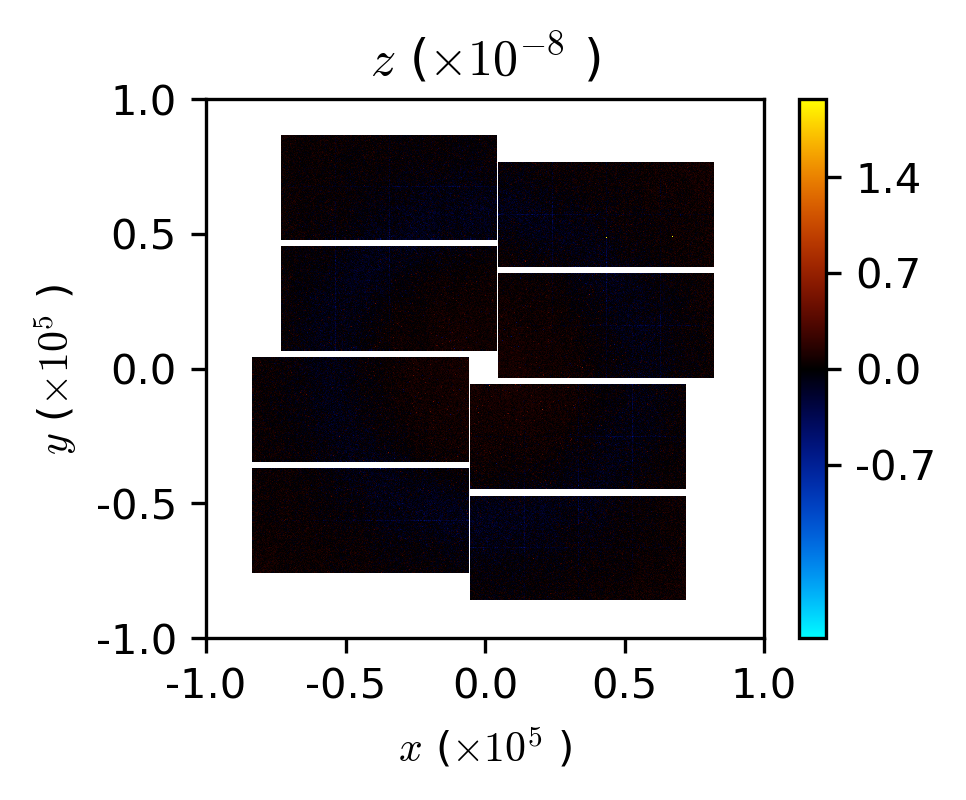

In [21]:
from IPython.display import clear_output
from plotStyles import *

def plotCSPAD( cspad , x , y, cspadMask=None, zLims = None, divergent=False, NTILE=8 ):
    figOpts = {'xLims':[-1e5,1e5],'yLims':[-1e5,1e5],'divergent':divergent, 'xIn':3, 'yIn':3*11.5/14.5}
    
    if zLims is not None:
        figOpts['zLims'] = zLims
    
    for iTile in range(NTILE):
    
        if cspadMask is not None:
            cspadTile = cspad[iTile,:,:]
            tileMask = ~cspadMask[iTile,:,:]
            cspadTile[tileMask] = 0
        
        if iTile == 0:
            newFigure = True
        else:
            newFigure = False
            
        clear_output()
        colorPlot( x[iTile,:,:], y[iTile,:,:], cspadTile , newFigure=newFigure, **figOpts);

x,y = CSPADgeometry(detType='Jungfrau', run=runNumber, experiment=experiment)
# cspadMask = createMask(detType='Jungfrau', run=runNumber, experiment=experiment)
cspadMask = np.ones_like(x).astype(bool)

CSPADbinned = CSPAD

plotCSPAD( CSPADbinned[:,:,:,2]-CSPADbinned[:,:,:,1], x , y , cspadMask=cspadMask, divergent=True, NTILE=8 )
# plotCSPAD( np.sum(CSPADbinned[:,:,:,:], axis=-1), x , y , cspadMask=cspadMask, divergent=False, NTILE=8 )

print CSPADbinned.shape

# Geometry

In [ ]:
# Read in geometry and geometry measure during beamtime
XC,YC = 88097, 93696
X=np.array(x-XC)
Y=np.array(y-YC)
R=np.sqrt(np.power(X,2)+np.power(Y,2))
L=69e3

# Use two-theta to calculate Q
TwoTheta=np.arctan(R/L)
Q = 4*np.pi*np.sin(TwoTheta/2)/1.3874;
print np.max(Q)
PHID = np.arctan2(X,Y)#Y,X)
THETAD = TwoTheta;

# Form the Thomson correction factor
# THOMSON_CORRECTION = PHID; 
THOMSON_CORRECTION = ((np.sin(PHID)**2+np.cos(THETAD)**2.*np.cos(PHID)**2)); 

# Legendre Analysis

# Mask the cspad images**

In [ ]:

CB=counts
ValidIdx=np.squeeze(CB>50)
Validbins=CB[ValidIdx]
ValidT=timebins[ValidIdx]
CSPADV=CSPAD[:,:,:,ValidIdx]
CSPAD_VAR=variance[:,:,:,ValidIdx]
NT=Validbins.shape[0]
CSPAD_MASKED=np.zeros((32,185,388,NT))
CSPAD_VAR_MASKED=np.zeros((32,185,388,NT))
CSPAD_MSTD_MASKED=np.zeros((32,185,388,NT))

Mask = cspadMask<1

iPlaced=0
for itrT in xrange(NT):
    print((itrT,NT))
    CSPAD_IMAGE = CSPADV[:,:,:,itrT]
    CSPAD_IMAGE_VAR = CSPAD_VAR[:,:,:,itrT]
    CSPAD_IMAGE_MSTD = np.sqrt(CSPAD_IMAGE_VAR / float(Validbins[itrT]))
    
    CSPAD_IMAGE[Mask > 0] =  np.nan*CSPAD_IMAGE[Mask > 0];
    CSPAD_IMAGE_VAR[Mask > 0] =  np.nan*CSPAD_IMAGE_VAR[Mask > 0];
    CSPAD_IMAGE_MSTD[Mask > 0] =  np.nan*CSPAD_IMAGE_MSTD[Mask > 0];
    
    CSPAD_MASKED[:,:,:,itrT]= CSPAD_IMAGE
    CSPAD_VAR_MASKED[:,:,:,itrT]= CSPAD_IMAGE_VAR
    CSPAD_MSTD_MASKED[:,:,:,itrT]= CSPAD_IMAGE_MSTD


## Rebinning from x,y to Qx,Qy to Q,theta

## x,y -> Qx,Qy

In [ ]:

time0 = time.time()
# NQ = 100
NQ = 250 # Must be divisible by 2
QMIN = 0.
QMAX = 4.5
qGrid = np.linspace(QMIN,QMAX,NQ)

# specify wavelength here, to give Q/pixel
k0 = 4.5287 # 2pi/lambda
scaling_fac = np.sqrt(1.-Q**2 / (4.* k0**2)) #scaling for molecular space
angles_old = np.arctan2(Y, X)
angles = np.arccos(scaling_fac*np.cos(angles_old))
QX = Q * np.absolute(np.cos(angles))
QY = Q * np.absolute(np.sin(angles))

indX = np.round(float(NQ)*QX/QMAX)
indX = indX.flatten()

indY = np.round(float(NQ)*QY/QMAX)
indY = indY.flatten()

## THIS IS RIGHT BUT I FORGOT NANS!!!!
my_filter = (Mask < 1).flatten()

my_imgs = np.reshape(CSPAD_MASKED/np.repeat(np.expand_dims(THOMSON_CORRECTION,3),NT,axis=3),(388*185*32, NT))
my_vars = np.reshape(CSPAD_VAR_MASKED/np.repeat(np.expand_dims(THOMSON_CORRECTION**2,3),NT,axis=3),(388*185*32, NT))
my_mstds = np.reshape(CSPAD_MSTD_MASKED/np.repeat(np.expand_dims(THOMSON_CORRECTION,3),NT,axis=3),(388*185*32, NT))
imgQ = np.zeros((NQ,NQ,NT))
varQ = np.zeros((NQ,NQ,NT))
mstdQ = np.zeros((NQ,NQ,NT))
numQ = np.zeros((NQ,NQ))

print 'Rebinning the CSPAD in Qx-Qy space between ', QMIN, ' and ', QMAX, 'using NQ = ', NQ

for iX in xrange(NQ):
    print 'Iteration [%d], Time elapse %f' % (iX,time.time()-time0)
    for iY in xrange(NQ):
        inds = (indX == iX)*(indY == iY)*(my_filter.astype(bool))
        
        numQ[iX,iY] += inds.sum()
        
        red_img = sum(np.compress(inds,my_imgs,axis=0))
        red_mstd = sum(np.compress(inds,my_mstds,axis=0))
        red_var = sum(np.compress(inds,my_vars,axis=0))
        
        imgQ[iX,iY,:] += np.squeeze(imgQ[iX,iY,:]) + red_img
        mstdQ[iX,iY,:] += np.squeeze(mstdQ[iX,iY,:]) + red_mstd
        varQ[iX,iY,:] += np.squeeze(varQ[iX,iY,:]) + red_var





In [ ]:
plotCSPAD( CSPADbinned[:,:,:,2], QX , QY , cspadMask=cspadMask, divergent=True )
plt.ylim([-QMAX,QMAX])
plt.xlim([-QMAX,QMAX])

## Plotting the difference signal in Qx-Qy

In [ ]:
from matplotlib import cm
plt.close()
fig, ax = plt.subplots()

plotQ = (imgQ[:,:,2]-imgQ[:,:,1])/numQ;
# plotQ[np.isnan(plotQ)] = 0
# plotQ = numQ;

# #cax = ax.imshow(data, interpolation='nearest', cmap=cm.coolwarm)#, vmin=-200, vmax=200)
# cax = ax.pcolormesh(QX.flatten(),QY.flatten(),plotQ.flatten())#, interpolation='nearest', cmap=cm.coolwarm)#, vmin=-200, vmax=2
cax = ax.imshow(plotQ) #, vmin=0, vmax=1e2)#, interpolation='nearest', cmap=cm.coolwarm)#, vmin=-200, vmax=200)
ax.set_title('Qx,Qy CSPAD image')

cbar = fig.colorbar(cax)

plt.show()

## Plotting the mean standard deviation in Qx-Qy

In [ ]:
from matplotlib import cm
plt.close()
fig, ax = plt.subplots()

plotQ = (mstdQ[:,:,2])/numQ;
# plotQ = numQ;

# #cax = ax.imshow(data, interpolation='nearest', cmap=cm.coolwarm)#, vmin=-200, vmax=200)
# cax = ax.pcolormesh(QX.flatten(),QY.flatten(),plotQ.flatten())#, interpolation='nearest', cmap=cm.coolwarm)#, vmin=-200, vmax=2
cax = ax.imshow(plotQ)#, vmin=0, vmax=1e2)#, interpolation='nearest', cmap=cm.coolwarm)#, vmin=-200, vmax=200)
ax.set_title('Qx,Qy CSPAD image')

cbar = fig.colorbar(cax)

plt.show()

## Qx, Qy -> Q, theta

In [ ]:
# Create the new `D Q and theta grids
NQ2 = NQ/2
# NQ2 = NQ/4
# NQ2 = NQ
qGrid2 = np.linspace(QMIN,QMAX,NQ2)
print 'Rebinning the CSPAD in Qx-Qy space between ', QMIN, ' and ', QMAX, 'using NQ = ', NQ2

NTHETAS = np.floor(np.pi*np.arange(NQ)/2)
NTHETA_MAX = NTHETAS[-1]

THETAS = np.zeros((NQ2,NTHETA_MAX))
for itr in xrange(NQ2):
    placeme=np.linspace(0,(np.pi)/2,NTHETAS[itr])
    THETAS[itr,0:len(placeme)]=placeme

# Initialize the storage arrays
imgQT=np.zeros((NQ2,NTHETA_MAX,NT))
mstdQT=np.zeros((NQ2,NTHETA_MAX,NT))
varQT=np.zeros((NQ2,NTHETA_MAX,NT))
numQT=np.zeros((NQ2,NTHETA_MAX))

# Find the original Q and angles
QX2, QY2=np.meshgrid(qGrid,qGrid)
Q2    = np.sqrt(QX2**2+QY2**2)
ANGLES=np.arctan2(QX2,QY2)

def find_nearest(array,value):
    try:
        idx = (np.abs(array-value)).argmin()
        return idx
    except ValueError:
        return 0

# Loop to place elements
time0=time.time()
for iQx in xrange(NQ):
    print 'Iteration [%d], Time elapse %f' % (iQx,time.time()-time0)
    for iQy in xrange(NQ):
        if numQ[iQx,iQy] > 0:
            idQ=find_nearest(qGrid2,Q2[iQx,iQy])
            idTH=find_nearest(np.squeeze(THETAS[idQ,0:NTHETAS[idQ]]),ANGLES[iQx,iQy])
            imgQT[idQ,idTH,:]+=imgQ[iQx,iQy,:]
            varQT[idQ,idTH,:]+=varQ[iQx,iQy,:]
            mstdQT[idQ,idTH,:]+=mstdQ[iQx,iQy,:]
            numQT[idQ,idTH]+=numQ[iQx,iQy]
 
print imgQT.shape

## Plot the image in Q, theta

In [ ]:
plt.close()
fig, ax = plt.subplots()

plotQ = (imgQT[:,:,2]-np.mean(imgQT[:,:,0:1],axis=2))/numQT

cax = ax.imshow(plotQ, interpolation='bicubic', cmap=cm.coolwarm)
# clims=np.array([-1,1])*1e-1
# cax = ax.imshow(plotQ, vmin=clims[0], vmax=clims[1], interpolation='bicubic', cmap=cm.coolwarm)#, vmin=-200, vmax=200)

ax.set_title('Q,theta CSPAD image')

cbar = fig.colorbar(cax)

plt.show()

## Plot mean standard deviation in Q, theta

In [ ]:
plt.close()
fig, ax = plt.subplots()

plotQ = (mstdQT[:,:,1])/numQT

cax = ax.imshow(plotQ, interpolation='bicubic', cmap=cm.coolwarm)
# clims=np.array([-1,1])*1e-1
# cax = ax.imshow(plotQ, vmin=clims[0], vmax=clims[1], interpolation='bicubic', cmap=cm.coolwarm)#, vmin=-200, vmax=200)

ax.set_title('Q,theta CSPAD image')

cbar = fig.colorbar(cax)

plt.show()

print np.sum(mstdQT < 0)

## Legendre Analysis

In [ ]:
from scipy.special import legendre

def orthonormal_legendre_poly(n):
    return legendre(n)*np.sqrt((2.*n+1.)/2.)

def orthonormal_legendre_eval(n,x):
    p = orthonormal_legendre_poly(n)
    return p(x)

def generate_orthonormal_legendre_mat(lmax,x,even_only=True):
    if even_only:
        DL = 2
        NL = lmax/2 + 1
    else:
        DL = 1
        NL = lmax + 1
        
    P = np.zeros((NL,x.shape[0]))
    for idx, l in enumerate(xrange(0,lmax+DL,DL)):
        P[idx,:] = orthonormal_legendre_eval(l,x)
        
    return P

def chi_square(mean,mean_std,model,x):
    v0 = np.dot(x,model)
    vd = (v0 - mean) / mean_std
    return np.dot(vd,vd)

def chi_square_min(mean,mean_std,model):
    fx = np.dot(model, mean/mean_std**2)
    B  = np.dot(np.dot(model, np.diag(mean_std**-2)),model.transpose())
#     print B
    Bi = np.linalg.solve(B.T.dot(B), B.T)
#     Bi = np.linalg.inv(B)
    A  = np.dot(Bi,model)
    
    xmin = np.dot(A,mean/mean_std**2)
    
#     print mean_std
    mstd = np.dot(np.abs(A),mean_std)
#     print mstd
    
    cs   = chi_square(mean,mean_std,model,xmin)
    return {'xmin':xmin,'mstd':mstd, 'error_ratio':mstd/xmin,'cs':cs}
  
def generate_chi_square_map( lmax, NTHETAS, THETAS, imgQT, varQT, numQT, NT, NQ2, even_only=True ):
    lm      = np.zeros((lmax/2+1,NQ2,NT))
    lmstd   = np.zeros((lmax/2+1,NQ2,NT))
    cs_sum  = []
    cs0_sum = []
    NP = 0
    ND = 0

    for iT in xrange(0,NT):
        for iQ in xrange(10,NQ2):
            iThs = np.arange(0,NTHETAS[iQ]).astype(int)

            ValidIdxs = numQT[iQ,iThs] > 0
            iThs = iThs[ValidIdxs]

            P = generate_orthonormal_legendre_mat(lmax,THETAS[iQ,iThs])

            # print imgQT[iQ,iThs,iT]/numQT[iQ,iThs]
            # print mstdQT[iQ,iThs,iT]/numQT[iQ,iThs]

            means = imgQT[iQ,iThs,iT]/numQT[iQ,iThs]
            mstds = np.sqrt(varQT[iQ,iThs,iT]/numQT[iQ,iThs])
            reg=np.max(np.abs(means))

            means = means/reg
            mstds = mstds/reg
            

            model = chi_square_min(means , mstds, P)
#             model = chi_square_min(means , np.sqrt(np.abs(means)), P)
#             model = chi_square_min(means , np.ones_like(means), P)
            lm[:,iQ,iT] = model['xmin']*reg
            lmstd[:,iQ,iT] = model['mstd']*reg
            
            cs_sum.append(model['cs'])
            cs0_sum.append( chi_square(means,mstds,P,np.zeros_like(model['xmin'])) )
            
            if ~np.isnan(cs_sum[iT]):
                NP+=lmax/2+1
                ND+=means.shape[0]
            
#     return lm, lmstd, np.nanmean(cs_sum)/(lmax/2+1), np.nanmean(cs0_sum)/(lmax/2+1)
    return lm, lmstd, np.nansum(cs_sum), np.nansum(cs0_sum), ND, NP
    

lmax = 6
lm, lmstd, cs, cs0, ND, NP = generate_chi_square_map(lmax, NTHETAS, THETAS, imgQT, varQT, numQT, NT, NQ2, even_only=True )


    





In [ ]:
l=0
t_inds = np.arange(0,NT).astype(int)

plt.close()
fig, ax = plt.subplots()

clims = np.array([-1,1])

plotme = lm[l,:,t_inds].transpose()
t0 = plotme[:,0]
plotme = plotme - t0[:,np.newaxis]

cax = ax.pcolormesh(ValidT[t_inds]+1.1,qGrid2,plotme)#,vmin=clims[0],vmax=clims[1])

cbar = fig.colorbar(cax)
plt.ylim([1.,4.])
# plt.xlim([-.2,1.5])
plt.show()

In [ ]:
l=0
t_inds = np.arange(0,NT).astype(int)

plt.close()
fig, ax = plt.subplots()

clims = np.array([-1,1])*2e1

plotme = lmstd[l,:,t_inds].transpose()
t0 = plotme[:,0]
plotme = plotme + t0[:,np.newaxis]

cax = ax.pcolormesh(ValidT[t_inds]+1.1,qGrid2,plotme,vmin=clims[0],vmax=clims[1])

cbar = fig.colorbar(cax)
plt.ylim([1.,4.])
# plt.xlim([-.2,1.5])
plt.show()

In [ ]:

import h5py

hf = h5py.File(os.environ['RESULTSPATH']+'/legendre-analysis-run-%d.h5' % runNumber, 'w')

hf.create_dataset('mean', data=lm)
hf.create_dataset('std', data=lmstd)
hf.create_dataset('timebins', data=ValidT)
hf.create_dataset('Q', data=qGrid2)
hf.create_dataset('legendres', data=np.array([0,2,4,6]))

hf.close()
